In [822]:
from scipy import stats
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

### utils

**Big Query**

In [823]:
import sys
import argparse
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from oauth2client.client import GoogleCredentials
credentials = GoogleCredentials.get_application_default()
bigquery_service = build('bigquery', 'v2', credentials=credentials)

def request(query):
    results = []
    query_request = bigquery_service.jobs()    
    query_data = {'query':query, 'timeoutMs':1000*60*60}
    query_response = query_request.query(projectId='imp-anomaly-research', 
                                             body=query_data).execute()
    results.append(query_response)
    page_token = query_response.get('pageToken',None)
    while page_token:
        jobId = query_response['jobReference']['jobId']
        q = query_request.getQueryResults(pageToken=page_token, 
                              projectId='imp-anomaly-research', 
                              jobId = jobId)
        query_response = q.execute()
        results.append(query_response)
        page_token = query_response.get('pageToken',None)
        
    for resp in results[1:]:
        results[0]['rows'] += resp['rows'] 

    return results[0]

### Notes

**z-statistic**

In [824]:
#Normal, p<0.05, 2-tail
stats.norm.ppf(1 - 0.025)

1.959963984540054

**t-statistic (Student)**

In [825]:
#Studnt, n=999, p<0.05, 2-tail
print stats.t.ppf(1-0.025, 999)

#Studnt, n=999, p<0.05, Single tail
print stats.t.ppf(1-0.05, 999)

1.96234146113
1.64638034543


### Example

**get all list**

In [826]:
#get all list
#one time lounch
if False:
    query = """
    select if(num_website is null, 0, num_website) as num_website
    from
    (select uuuu, num_all, num_website
    from [imp-anomaly-research:rules.bid_uuid_rule_cache_20170622] t1
    
    left join

    (select bid_uuid, num_all, num_website 
    from
    (select 
     sum(if(inventory_type='website', 1, 0))*150 as num_website,
     count(*)*150 as num_all,
     bid_uuid
    from [bidswitch:userver_logs.ssp_bid_compressed_v45_20170622]
    group by bid_uuid)) as t2
    on t1.uuuu = t2.bid_uuid)"""
    
    all_nums = request(query)
    bids = np.array([int(row['f'][0]['v']) for row in  all_nums["rows"]])
    del all_nums
    np.savetxt("others/rule_uuid_blocked_bids", bids, fmt='%i')

#open prepared file
with open("others/rule_uuid_blocked_bids", 'r') as f:
    bids = np.array(map(int,f.readlines()))
    
all_bids_20170622 = 374741269500 #population size

**find confidence interval**

In [827]:
sample_size = 10000
popul_size = bids.size
alpha = 0.05

In [828]:
#prepare random sample
if sample_size <= popul_size:
    sample = np.random.choice(bids, size = sample_size, replace = False) 
else:
    print "sample size is more population size"
    
mean_sample = sample.mean()  #sample

standartError = sample.std()/np.sqrt(sample_size)  #or sample.std() instead bids.std()
print "standartError = {}".format(standartError)

t_statistic = stats.t.ppf(1.-alpha/2, sample_size) #reliability factor for 1 - alpha confidence interval, 2-tail

print "t_statistic = {}".format(t_statistic)

upper_bound = mean_sample + t_statistic*standartError
lower_bound = max(mean_sample - t_statistic*standartError, 0)

print "upper_bound = {}".format(upper_bound)
print "mean_sample = {}".format(mean_sample)
print "lower_bound = {}".format(lower_bound)
print "width = {}".format(t_statistic*standartError/mean_sample)
print "blocked_pct_upper = {}".format(100*(upper_bound*popul_size)/all_bids_20170622)
print "blocked_pct_lower = {}".format(100*(lower_bound*popul_size)/all_bids_20170622)

standartError = 120.408076282
t_statistic = 1.96020123989
upper_bound = 1915.51406042
mean_sample = 1679.49
lower_bound = 1443.46593958
width = 0.140533174012
blocked_pct_upper = 1.16882969574
blocked_pct_lower = 0.880790117819


** find true sample size **

In [829]:
#width -  half of desired confident interval, pct
width = 0.1
alpha = 0.05

In [830]:
from scipy.optimize import fsolve

stdDev_popul = bids.std()
mean_popul = bids.mean()

def get_t(alpha, n):
    return stats.t.ppf(1.-alpha/2, n)
def func(n):
    return width - get_t(alpha, n)*stdDev / np.sqrt(n) / mean_popul
sampleSizeRequired = fsolve(func, 100)[0]
print int(sampleSizeRequired)

11390


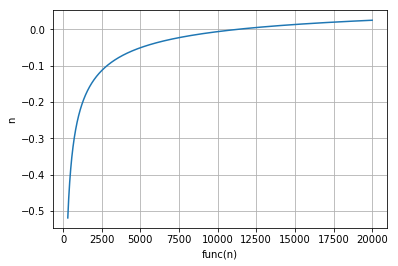

In [831]:
n = np.linspace(300,20000, 5000)
plt.plot(n, func(n))
plt.xlabel("func(n)")
plt.ylabel("n")
plt.grid()
plt.show()

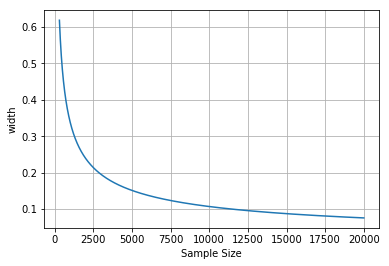

In [832]:
width = lambda n: get_t(alpha, n)*stdDev / np.sqrt(n) / mean_popul
n = np.linspace(300,20000, 5000)
plt.plot(n, width(n))
plt.xlabel("Sample Size")
plt.ylabel("width")
plt.grid()
plt.show()